In [9]:
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)

In [39]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [46]:
%%R
sample.data = data.frame(sample_data(physeq))

In [123]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Month, Trtmt){
    physeq.pruned <- prune_samples((sample_data(physeq)$Month == Month) & ((sample_data(physeq)$Trtmt == Trtmt) | (sample_data(physeq)$Trtmt == "S")),physeq)
    taxonomy <- data.frame(tax_table(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Trtmt)
    dseq$Trtmt = relevel(dseq$Trtmt,"S")
    #dseq$Trtmt = droplevels(desq$Trtmt)
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq)
    results$Month = Month
    results$Trtmt = Trtmt
    results = data.frame(results$Month,results$Trtmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy$Phylum)
    colnames(results) = c("Month","Trtmt","OTU","baseMean","l2FC","SE","pvalue","Phylum")
    results
    }

In [124]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Trtmt = c("Q", "F", "K","H"),
                        Month = c(2, 2.5, 3))
variables

   Trtmt Month
1      Q   2.0
2      F   2.0
3      K   2.0
4      H   2.0
5      Q   2.5
6      F   2.5
7      K   2.5
8      H   2.5
9      Q   3.0
10     F   3.0
11     K   3.0
12     H   3.0


In [125]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels
In addition: Warning messages:
1: In brewer.pal(20, "Dark2") :
  n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors

2: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
3: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
4: In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]) : 
  contrasts can be applied only to factors with 2 or more levels


In [126]:
%%R
head(DA)

  Month Trtmt        OTU  baseMean       l2FC       SE    pvalue         Phylum
1     2     Q   59_31177 0.0000000         NA       NA        NA  Acidobacteria
2     2     Q  52_374818 0.1435319 -0.6173796 2.561859 0.8095637  Acidobacteria
3     2     Q 95_1222810 0.6467538  1.2933424 2.275190 0.5697263 Proteobacteria
4     2     Q   2_976622 0.0000000         NA       NA        NA Proteobacteria
5     2     Q  65_942692 1.3620826  2.3591041 1.626242 0.1468781 Proteobacteria
6     2     Q   7_125682 1.9984384 -0.4343198 1.771362 0.8063095 Proteobacteria


In [127]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

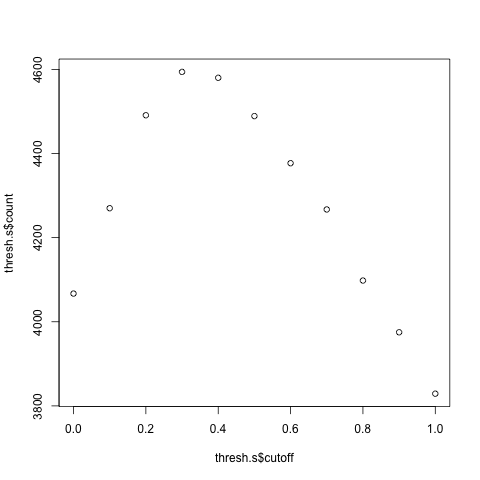

In [128]:
%%R
range = seq(0,1,0.1)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.3)

In [129]:
%%R
filter(DA,baseMean>=0.3) %>% mutate(padj = p.adjust(pvalue,"BH")) %>% write.csv("../../SeqData/l2fc.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [130]:
%%R
l2fc<-read.csv("../../SeqData/l2fc.csv")
head(l2fc)

  Month Trtmt        OTU  baseMean       l2FC       SE     pvalue
1     2     Q 95_1222810 0.6467538  1.2933424 2.275190 0.56972626
2     2     Q  65_942692 1.3620826  2.3591041 1.626242 0.14687813
3     2     Q   7_125682 1.9984384 -0.4343198 1.771362 0.80630953
4     2     Q  58_735746 0.5025454 -1.7391473 2.648443 0.51139459
5     2     Q 104_423826 0.7817250 -1.9095696 2.635427 0.46871170
6     2     Q  91_159495 4.6514315  2.2728667 1.059449 0.03192661
          Phylum      padj
1 Proteobacteria 0.7031080
2 Proteobacteria 0.2973980
3 Proteobacteria 0.8724516
4 Proteobacteria 0.6572038
5 Proteobacteria 0.6227213
6 Proteobacteria 0.1007129


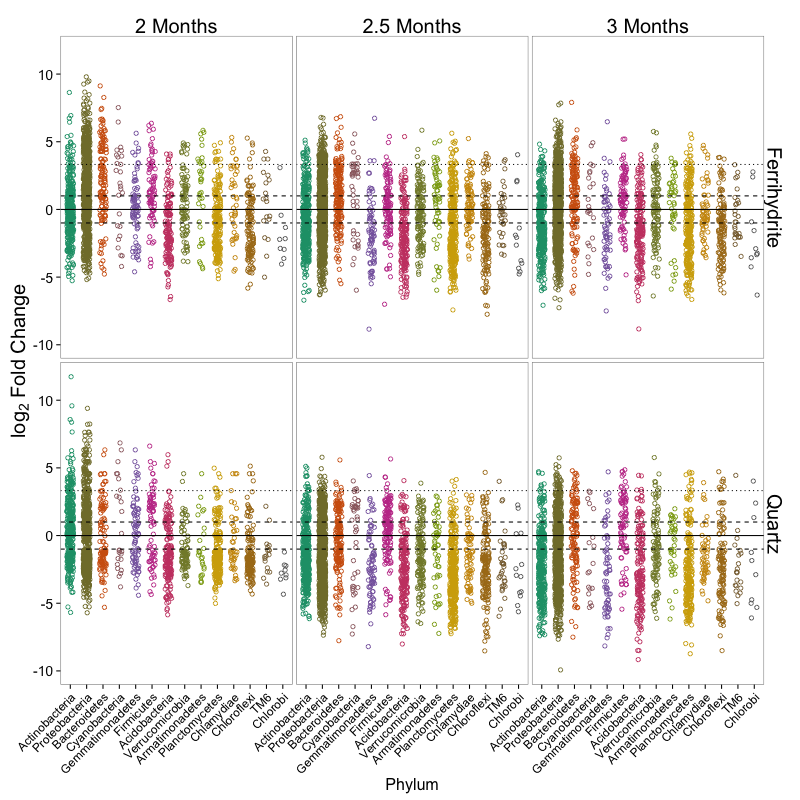

In [193]:
%%R -w 800 -h 800
# setting the image sizes, then making the figure...

d = l2fc

#d$Phylum = substr(as.character(d$Phylum),0,nchar(as.character(d$Phylum)))
# makes the Rank2 column of our d table a character. Rank 2 was the phyla of our communities

#d$Phylum[is.na(d$Phylum)] <- "Unclassified"
# if there is an NA in the Rank2 column, then it gets called "unclassified"

#d$Phylum = factor(d$Phylum)
# Establishes that Rank2 is a factor.

#levels(d$Phylum)[levels(d$Phylum) == "[Thermi]"] <- "Thermi"
#levels(d$Phylum)[levels(d$Phylum) == ""] <- "Unclassified"
#levels(d$Phylum)[levels(d$Phylum) == "NA"] <- "Unclassified"
# Fixes two phylum labelling issues

N=50
Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)


d$MonthName = ifelse(d$Month==2,"2 Months",(ifelse(d$Month==2.5, "2.5 Months","3 Months")))
d$strip1 = paste(d$MonthName)
d$TrtmtName = ifelse(d$Trtmt=="H","Heavy Fraction",ifelse(d$Trtmt=="Q","Quartz",ifelse(d$Trtmt=="F","Ferrihydrite",ifelse(d$Trtmt=="K","Kaolinite",""))))
#d$TrtmtName <- factor(d$TrtmtName, levels = c("Stover","PyOM"))
d$strip2 = paste(d$TrtmtName)
# Creates a "strip" column of d with either Day or Amendment

max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values
#d$color = ifelse(d$p.adj <= 0.05, "yes", "no")
# looks at the p.adj value, to see if it's less than or equal to what we set it to here.
# If it is less ("significant") then we label it yes. Otherwise, no.

M = max(as.numeric(d$Phylum), na.rm = TRUE) + 1
d$x = as.numeric(d$Phylum)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.25

p = ggplot(d, aes(x = Phylum, y = l2FC, color = Phylum))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~strip2~strip1)
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, size = 2, position = position_jitter(w = 0.20))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_blank(),
              legend.text = element_text(size = 14),
              legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Phylum", color = "Phylum")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))
# sets the label for the y axes.

colourCount = length(unique(d$Phylum))
getPalette = colorRampPalette(brewer.pal(8, "Dark2"))
p = p + scale_colour_manual(values=getPalette(colourCount))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p